# **EDA**


En este notebook se dispone de un análisis detallado de los datos proporcionados por la página de videojuegos STEAM, esto con la finalidad de tener a disposición un informe de la calidad de los datos y las irregularidades que se puedan presentar, se utilizarán tres Datasets para este proyecto:

steam_games: Corresponde al conjunto de videojuegos de los que dispone la plataforma junto con algunas de sus características.

user_items: Contiene la lista de items adquiridos por cada usuario, ademas del tiempo de uso que se le ha dado a cada uno.

user_reviews: Presenta la calificacion de las reseñas hechas por los usuarios en la plataforma.


Se debe tener en cuenta que estos datos ya han sido debidamente procesados, se han filtrado y depurado con la idea de realizar un sistema de recomendación para usuarios, por lo tanto cabe aclarar que se han tomado los parámetros más relevantes que permiten comparar y clasificar items.

Lo primero que se debe hacer es cargar los datos, user_items por temas de almacenamiento se ha fragmentado en tres datasets diferentes, se procede a unificarlo nuevamente:



In [1]:
import pandas as pd

user_reviews= pd.read_csv('user_reviews.csv',sep=';',encoding='utf-8')
steam_games = pd.read_csv('steam_games.csv',sep=';',encoding='utf-8')
user_items1 = pd.read_csv('user_items1.csv',sep=';',encoding='utf-8')
user_items2 = pd.read_csv('user_items2.csv',sep=';',encoding='utf-8')
user_items3 = pd.read_csv('user_items3.csv',sep=';',encoding='utf-8')

user_items= pd.concat([user_items1, user_items2, user_items3],axis=0, ignore_index=True)



Hay algunos datos de tipo set que al momento de cargar el archivo los lee como una cadena de texto, por lo tanto es conveniente transformar esas columnas al tipo de dato correcto antes de continuar.

In [2]:
import ast

# Función para convertir la cadena a un conjunto
def convert_to_set(column):
    try:
        # Utilizamos ast.literal_eval para evaluar la cadena como una expresión literal de Python

        return ast.literal_eval(column)
    except (SyntaxError, ValueError):
        # Si hay un error al evaluar la cadena, puedes manejarlo de alguna manera
        return set('No data')

# Aplicar la función a la columna 'genres'
user_items['genres'] = user_items['genres'].apply(convert_to_set)
steam_games['genres']= steam_games['genres'].apply(convert_to_set)
steam_games['specs']=steam_games['specs'].apply(convert_to_set)


# **Datos faltantes**

Vamos a hablar acerca de los datos que faltan y cómo podrian afectar nuestro trabajo.

En primera instancia veremos que los usuarios poseen items que no estan en la tabla de juegos de steam.

In [3]:

#Este es el conjunto de juegos que hay en user_items
juegos_items=set(user_items.drop_duplicates(subset='item_id')['item_id'])

#Este es el conjunto de juegos que hay en steam_games
juegos_steam=set(steam_games.drop_duplicates(subset='item_id')['item_id'])

#Vemos si un conjunto está contenido en el otro
print(juegos_items in juegos_steam)#False

False


Como se observa hay juegos que poseen los usuarios que no estan en el Dataset de steam_games, es de interés estudiar qué tipo de juegos exactamente tienen los usuarios.

In [4]:
id_faltantes=juegos_items-juegos_steam

#Hallo el nombre de los juegos que faltan

juegos_extra=user_items[user_items['item_id'].isin(id_faltantes)]['item_name']

print(juegos_extra)

16               Company of Heroes: Opposing Fronts
31                                         Droplitz
34                            Batman: Arkham Asylum
40                                    Battlefield 2
41                        Painkiller: Black Edition
                             ...                   
3285208    Call of Duty: Black Ops II - Multiplayer
3285209        Call of Duty: Black Ops II - Zombies
3285231                              Moonbase Alpha
3285236                                      Moirai
3285245                                  Minds Eyes
Name: item_name, Length: 417191, dtype: object


Se puede ver que en steam_games faltan 417191 juegos que poseen los usuarios, por ejemplo 'Battlefield 2' o 'Call of Duty: Black Ops II - Zombies'. Esto nos pone en un problema, significa que nos faltan los generos y los años de lanzamiento de todos esos juegos sumado a los datos que ya faltaban desde un inicio.
En el ETL se detectó que faltaba la tercera parte de las fechas de lanzamiento, se hizo un trabajo de scrapping sobre Wikipedia para reducir exitosamente es número a la mitad.

In [5]:
#Hallo la relación entre el número de juegos sin fecha y el número total de juegos
user_items_sin_duplicados=user_items.drop_duplicates(subset='item_id')
juegos_sin_fecha=user_items_sin_duplicados[user_items_sin_duplicados['release_date']=='No data']


print(juegos_sin_fecha.shape[0]/user_items_sin_duplicados.shape[0])

0.18567164179104478


Se observa que falta el 0.18 de las fechas de lanzamiento, antes del scrapping esta relación ascendía a casi el doble. Otro conjunto de datos faltante importante a tener en cuesta es de las fechas de publicación de la reseña del usuario, estudiemos la relación.

In [6]:
reviews_sin_fecha=user_reviews[user_reviews['posted']=='No data']

print(reviews_sin_fecha.shape[0]/user_reviews.shape[0])

0.17498302783435166


Como se puede observar es una relación parecida a la de las fechas de lanzamiento, para no perder la valoración sentimental de las reseñas que se consideran de gran importancia se optó por dejar estos datos faltantes.

# **Outliers**

El outlier de principal importancia es el de las horas jugadas por usuario, queremos ver que sean datos realistas y dentro de lo que se considera normal para un jugador.

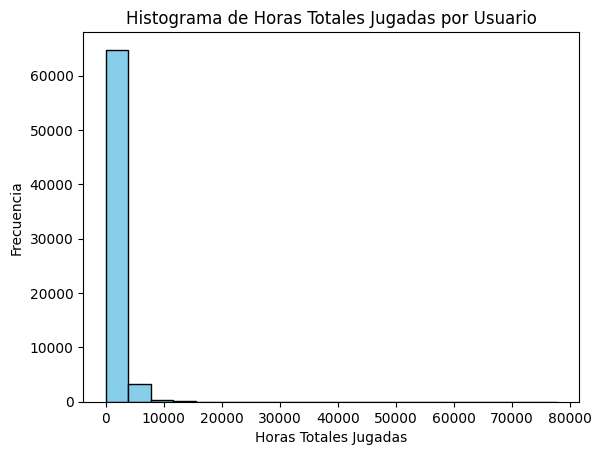

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcula las horas totales por usuario
horas_totales_por_usuario = user_items.groupby('user_id')['playtime_forever'].sum()
horas_totales_por_usuario = horas_totales_por_usuario.apply(lambda x: x/60)

# Crea un histograma
plt.hist(horas_totales_por_usuario, bins=20, color='skyblue', edgecolor='black')

# Personaliza el gráfico
plt.title('Histograma de Horas Totales Jugadas por Usuario')
plt.xlabel('Horas Totales Jugadas')
plt.ylabel('Frecuencia')

# Muestra el gráfico
plt.show()

Se observa que no es una distribución normal, por lo tanto no se puede aplicar el criterio de las tres sigmas. Teniendo en cuenta que steam se fundó en 2003 y los datos llegan hasta 2018, decido tomar como dato máximo admitido una persona que jugó 2 horas al día todos los días del año.Dando un total de 11000 horas que equivale a 660000 minutos.

In [8]:
horas_totales_por_usuario = user_items.groupby('user_id')['playtime_forever'].sum().reset_index()

# Filtra los usuarios que jugaron en total menos o igual a 660,000 minutos
usuarios_filtrados = horas_totales_por_usuario[horas_totales_por_usuario['playtime_forever'] <= 660000]

# Filtra 'user_items' para retener solo las filas correspondientes a los usuarios filtrados
user_items_filtrado = user_items[user_items['user_id'].isin(usuarios_filtrados['user_id'])]

user_items= user_items_filtrado

# **Juegos populares**

Es de interés saber qué tipo de juegos le gustan a los usuarios para que los desarrolladores puedan maximizar sus ganancias en lanzamientos futuros. A continuación se muestran los 10 juegos más jugados:

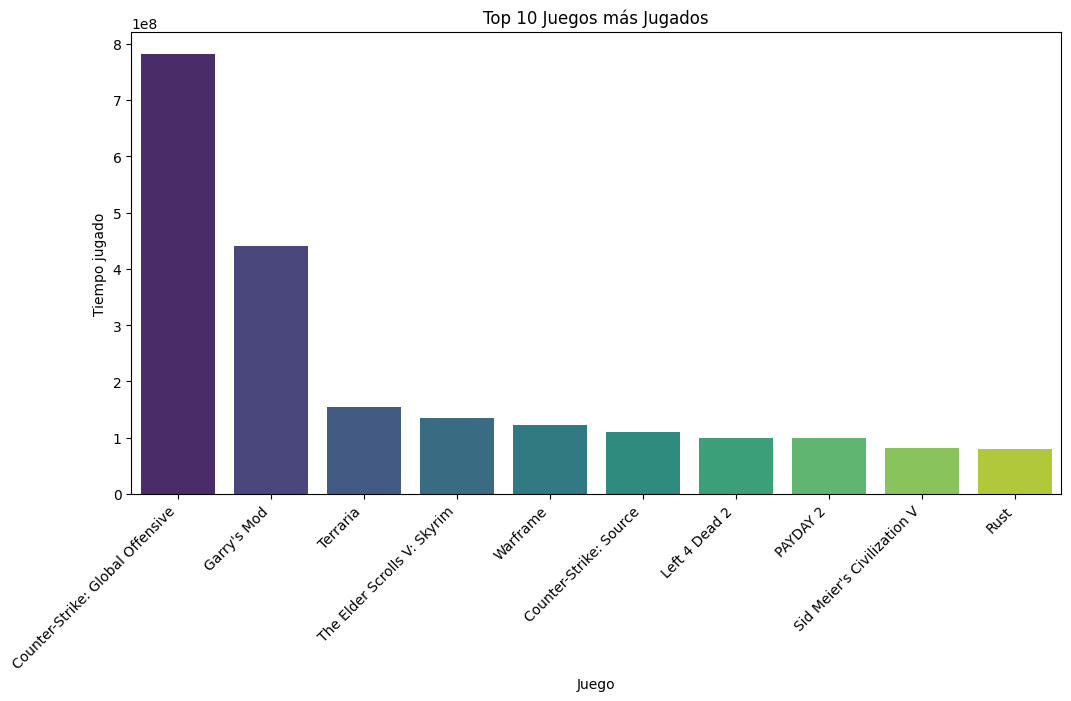

In [14]:
# Calculo las horas totales por juego
minutos_por_juego = user_items.groupby('item_name')['playtime_forever'].sum().sort_values(ascending=False)

# Seleccion0 los 10 juegos más jugados
top_10_juegos = minutos_por_juego.head(10)

# Creo un histograma
plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_juegos.index, y=top_10_juegos.values, palette='viridis')
plt.title('Top 10 Juegos más Jugados')
plt.xlabel('Juego')
plt.ylabel('Tiempo jugado')
plt.xticks(rotation=45, ha='right')  # Rotar etiquetas en el eje x para mejor legibilidad
plt.show()


Como se puede observar Counter-Strike es el juego más jugado de steam, en general el género acción es bastante popular y podriamos estudiar tendencias con la clasificación de cada juego.

Por último se exporta el archivo user_items con los outliers removidos.

In [16]:
user_items.to_csv('user_items.csv', sep=';',index=False)

